Data loaded from csv. Formatting...
45949
Shift:  6.997708419517081
Data:  (45929, 20)

Data Loaded. Compiling...

Compilation Time :  0.0011620521545410156
Epoch 1/2
81/81 [==============================] - 2s 21ms/step - loss: 8.8706 - mae: 1.7630 - mape: 1460.1932 - val_loss: 3.4256 - val_mae: 1.3506 - val_mape: 1483.1216
Epoch 2/2
5/5 [==============================] - 0s 5ms/step - loss: 0.6190 - mae: 0.5715 - mape: 399.4040

Evaluation results: 
MSE=0.618959
mae=0.571489
MAPE=399.404022


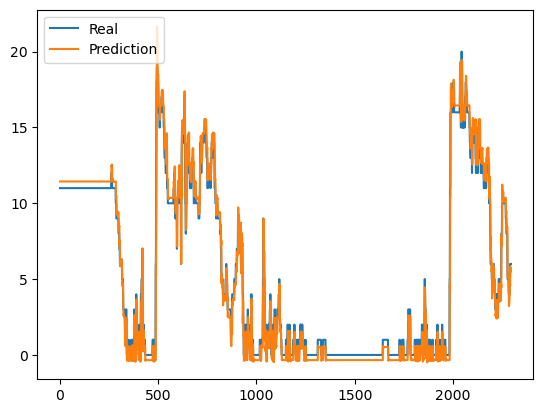

In [2]:
# Importing necessary libraries for plotting, numerical operations, timing, and data processing
import matplotlib.pyplot as plt
import numpy as np
import time
import csv
# Importing Keras components for building the model
from keras.layers.core import Dense, Activation, Dropout
from tensorflow.keras.layers import SimpleRNN
from keras.models import Sequential, load_model

# Initialize a list to store bike rental counts
bikes = []

# Function to load and prepare bike rental data from a CSV file
def data_bike_num(path_to_dataset='bike_rnn.csv',
                           sequence_length=20,
                           ratio=1.0):
    max_values = ratio * 45949  # Define max data points to load based on the given ratio
    with open(path_to_dataset) as f:  # Open the dataset file
        data = csv.reader(f, delimiter=",")  # Read the dataset as CSV
        next(data, None)  # Skip the header row
        nb_of_values = 0  # Counter for loaded data points
        for line in data:  # Loop over each line in the CSV
            try:
                bikes.append(float(line[0]))  # Try to convert the first column to float and append to bikes list
                nb_of_values += 1
            except ValueError:
                pass  # Ignore lines that cannot be converted to float
            if nb_of_values >= max_values:
                break  # Stop loading data if max_values is reached
    print("Data loaded from csv. Formatting...")
    print(len(bikes))
    
    result = []  # Initialize a list to store sequences of bike rental counts
    # Create sequences of the specified length from the bike rental counts
    for index in range(len(bikes) - sequence_length):
        result.append(bikes[index: index + sequence_length])
    result = np.array(result)  # Convert the list of sequences into a NumPy array
    result_mean = result.mean()  # Calculate the mean of the result array
    result -= result_mean  # Center the data by subtracting the mean
    print("Shift: ", result_mean)
    print("Data: ", result.shape)
    # Split the data into training and testing sets based on the specified row index
    row = int(round(0.95 * result.shape[0]))
    train = result[:row, :]
    np.random.shuffle(train)  # Shuffle the training data
    # Separate the sequences into input (X) and target (y) data for training and testing
    X_train = train[:, :-1]
    y_train = train[:, -1]
    X_test = result[row:, :-1]
    y_test = result[row:, -1]
    # Reshape the input data to add an extra dimension (required by SimpleRNN)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    return [X_train, y_train, X_test, y_test, result_mean]

# Function to define and compile the RNN model
def build_model():
    model = Sequential()  # Initialize the model as a sequential model
    layers = [1, 50, 100, 1]  # Define the size of each layer in the model
    # Add a SimpleRNN layer with return_sequences=True to keep the time dimension for the next layer
    model.add(SimpleRNN(layers[1], input_shape=(None, layers[0]), return_sequences=True))
    model.add(Dropout(0.2))  # Add dropout for regularization
    # Add another SimpleRNN layer, this time return_sequences=False because it's followed by Dense layers
    model.add(SimpleRNN(layers[2], return_sequences=False))
    model.add(Dropout(0.2))  # Add another dropout layer
    model.add(Dense(layers[3]))  # Add a Dense layer with 1 unit for the output
    model.add(Activation("linear"))  # Use a linear activation function for the output
    start = time.time()  # Start timing the compilation
    # Compile the model with mean squared error loss and RMSprop optimizer
    model.compile(loss="mse", optimizer="rmsprop", metrics=['mae', 'mape'])
    print("Compilation Time : ", time.time() - start)  # Print the compilation time
    return model

# Record the start time of the entire process
global_start_time = time.time()
# Set the number of epochs, ratio, sequence length, and path to the dataset
epochs = 2
ratio = 1
sequence_length = 20
path_to_dataset = 'bike_rnn.csv'
# Call the data loading and preprocessing function with the specified parameters to obtain the training and testing datasets, along with the mean value of the result set for normalization purposes.
X_train, y_train, X_test, y_test, result_mean = data_bike_num(path_to_dataset, sequence_length, ratio)

# Printing a message to indicate that the data loading and preprocessing step is complete and model compilation is about to start.
print('\nData Loaded. Compiling...\n')

# Calling the model building function to construct and compile the RNN model according to the specified architecture and compilation settings.
model = build_model()

# Training the model on the preprocessed training data. Here, we specify the batch size, number of epochs, and the fraction of data to be used as validation data.
model.fit(X_train, y_train, batch_size=512, epochs=epochs, validation_split=0.05)

# After training, we use the model to predict the output for the testing dataset.
predicted = model.predict(X_test)

# The predicted values are reshaped to match the size of the testing target data for evaluation purposes.
predicted = np.reshape(predicted, (predicted.size,))

# The trained model is evaluated using the testing dataset to calculate the loss and other metrics like Mean Squared Error (MSE), Mean Absolute Error (MAE), and Mean Absolute Percentage Error (MAPE).
scores = model.evaluate(X_test, y_test, batch_size=512)

# Printing the evaluation results, including MSE, MAE, and MAPE, to assess the performance of the model.
print("\nEvaluation results: \nMSE={:.6f}\nmae={:.6f}\nMAPE={:.6f}".format(scores[0], scores[1], scores[2]))

# Before plotting the real and predicted values, both are adjusted by adding back the mean value that was subtracted during data preprocessing to ensure the values represent the original scale.
y_test += result_mean
predicted += result_mean

# Initializing a figure for plotting.
fig = plt.figure()

# Adding a subplot to the figure where the real and predicted bike rental numbers will be plotted.
ax = fig.add_subplot(111)

# Plotting the real (actual) bike rental numbers on the subplot.
ax.plot(y_test, label="Real")

# Adding a legend to the upper left corner of the plot to identify the real data.
ax.legend(loc='upper left')

# Plotting the predicted bike rental numbers on the same subplot for comparison.
plt.plot(predicted, label="Prediction")

# Adding a legend to the upper left corner of the plot (which now includes both real and predicted data lines) for easy identification.
plt.legend(loc='upper left')

# Displaying the plot with the real and predicted values.
plt.show()
